# Bank Transaction Fraud Detection using Machine Learning

This notebook demonstrates an end-to-end machine learning pipeline for detecting fraudulent financial transactions using real-world, highly imbalanced banking data.

The focus is on:
- Proper handling of class imbalance
- Business-oriented evaluation metrics
- Comparing linear and non-linear models from a banking perspective


In [1]:
# =========================
# Imports
# =========================
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns


# =========================
# Configuration
# =========================
DATA_DIR = "/kaggle/input/creditcardfraud"   # Kaggle dataset folder
TRAIN_FILE = "creditcard.csv"
RAW_TARGET_COL = "Class"   # original dataset column
TARGET_COL = "isFraud"     # banking-friendly name
RANDOM_STATE = 42


In [2]:
train_path = os.path.join(DATA_DIR, TRAIN_FILE)
print("Reading data from:", train_path)

df = pd.read_csv(train_path)

print("Dataset shape:", df.shape)
df.head()


Reading data from: /kaggle/input/creditcardfraud/creditcard.csv
Dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df = df.rename(columns={RAW_TARGET_COL: TARGET_COL})

df[TARGET_COL].value_counts(normalize=True)
# Basic dataset info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Time     284807 non-null  float64
 1   V1       284807 non-null  float64
 2   V2       284807 non-null  float64
 3   V3       284807 non-null  float64
 4   V4       284807 non-null  float64
 5   V5       284807 non-null  float64
 6   V6       284807 non-null  float64
 7   V7       284807 non-null  float64
 8   V8       284807 non-null  float64
 9   V9       284807 non-null  float64
 10  V10      284807 non-null  float64
 11  V11      284807 non-null  float64
 12  V12      284807 non-null  float64
 13  V13      284807 non-null  float64
 14  V14      284807 non-null  float64
 15  V15      284807 non-null  float64
 16  V16      284807 non-null  float64
 17  V17      284807 non-null  float64
 18  V18      284807 non-null  float64
 19  V19      284807 non-null  float64
 20  V20      284807 non-null  

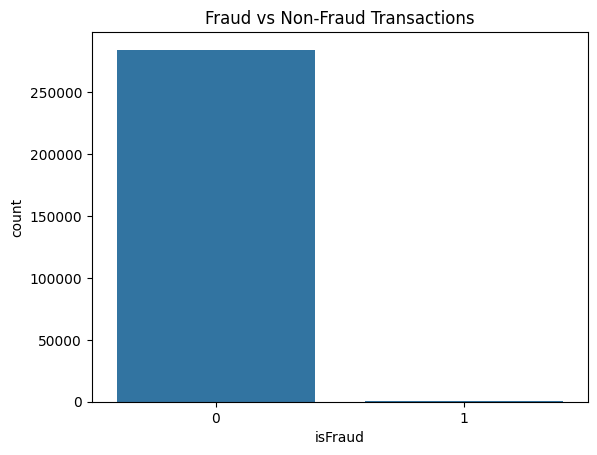

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=TARGET_COL, data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()


The dataset is highly imbalanced, which is typical in real-world banking fraud detection problems. Therefore, accuracy alone is not a reliable evaluation metric.

In [5]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (284807, 30)
Target shape: (284807,)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train fraud ratio:", y_train.mean())
print("Validation fraud ratio:", y_val.mean())


Train fraud ratio: 0.001729245759178389
Validation fraud ratio: 0.0017204452090867595


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Scaled train shape:", X_train_scaled.shape)
print("Scaled validation shape:", X_val_scaled.shape)


Scaled train shape: (227845, 30)
Scaled validation shape: (56962, 30)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr = LogisticRegression(
    class_weight="balanced",   # critical for fraud
    max_iter=1000,
    random_state=RANDOM_STATE
)

lr.fit(X_train_scaled, y_train)

y_val_pred_lr = lr.predict(X_val_scaled)

print("Logistic Regression — Validation Results")
print(classification_report(y_val, y_val_pred_lr))


Logistic Regression — Validation Results
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



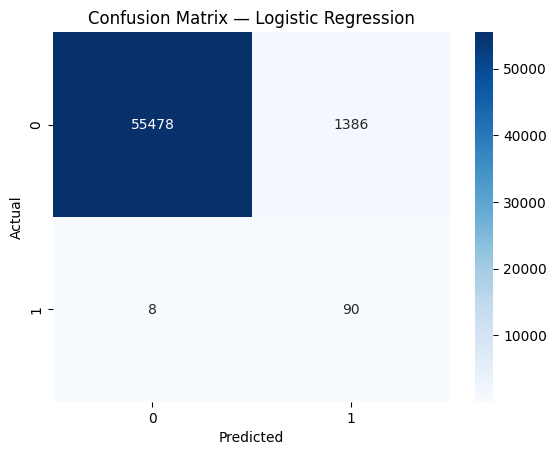

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_lr = confusion_matrix(y_val, y_val_pred_lr)

sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train, y_train)   # RF does NOT need scaled data

y_val_pred_rf = rf.predict(X_val)

print("Random Forest — Validation Results")
print(classification_report(y_val, y_val_pred_rf))


Random Forest — Validation Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962



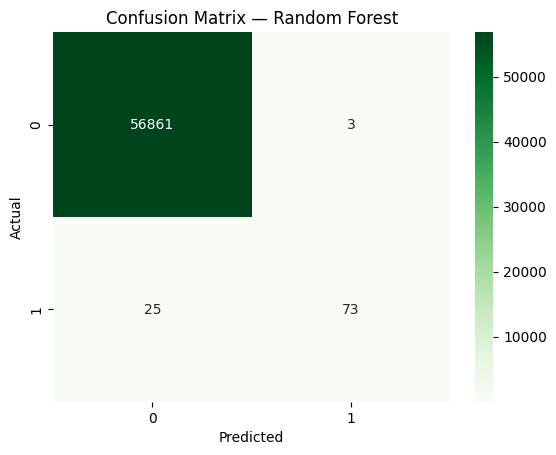

In [11]:
cm_rf = confusion_matrix(y_val, y_val_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [12]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Fraud Precision": [0.06, 0.96],
    "Fraud Recall": [0.92, 0.74],
    "Fraud F1": [0.11, 0.84]
})

comparison


,Model,Fraud Precision,Fraud Recall,Fraud F1
0,Logistic Regression,0.06,0.92,0.11
1,Random Forest,0.96,0.74,0.84


## Conclusions

This project demonstrates how different machine learning models behave under real-world banking constraints.

- Logistic Regression provides high fraud recall, making it suitable for early-stage fraud screening.
- Random Forest significantly improves precision, reducing false positives and customer friction.
- Accuracy alone is misleading in fraud detection due to extreme class imbalance.

Model selection should depend on business priorities such as fraud risk tolerance and customer experience.
